In [1]:
#!pip install -r requirements.txt
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
#!pip install keras
#!pip uninstall keras tensorflow
#!pip install tensorflow
#pip install tensorflow
from tensorflow import keras
#print(keras.__version__)


In [3]:
#Imports


In [4]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [5]:
# Create a meta file for nii files processing
path = "C:/Users/dellG15/Documents/liverCysts"
file_list = []
for dirname, _, filenames in os.walk('C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('C:/Users/dellG15/Documents/liverCysts/archive'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
0,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\segmentations,segmentation-0.nii
1,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\segmentations,segmentation-1.nii
2,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\segmentations,segmentation-10.nii
3,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\segmentations,segmentation-100.nii
4,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\segmentations,segmentation-101.nii
...,...,...
227,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-95.nii
228,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-96.nii
229,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-97.nii
230,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-98.nii


In [6]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\volume_pt1,volume-0.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\volume_pt1,volume-1.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation\volume_pt1,volume-10.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-100.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt8,volume-101.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-95.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-96.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-97.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,C:/Users/dellG15/Documents/liverCysts/archive\volume_pt6,volume-98.nii,C:/Users/dellG15/Documents/liverCysts/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [7]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
# Read sample

sample = 50
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 668)
Mask Shape: (512, 512, 668)


In [9]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-1024.0 3071.0
0.0 2.0


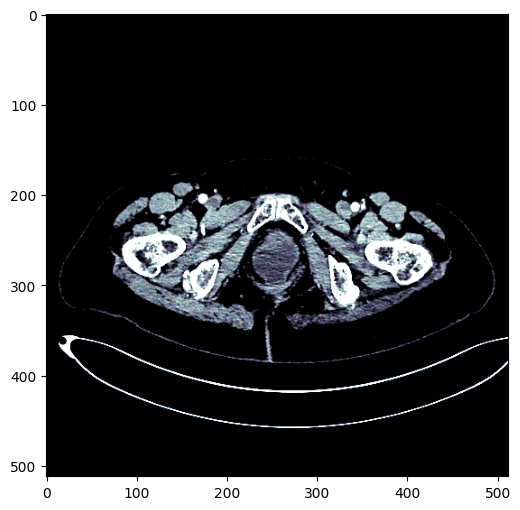

In [10]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);


CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)
-3024.0 1410.0
0.0 2.0


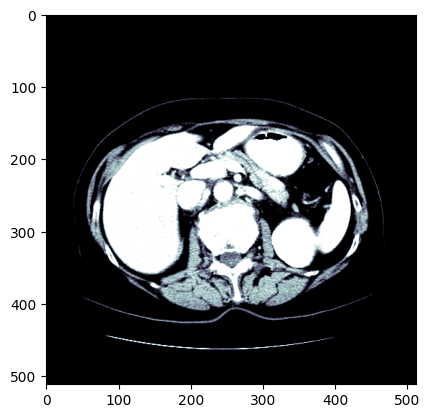

In [11]:
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [12]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('on')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('on')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('on')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('on')
    
    plt.show()

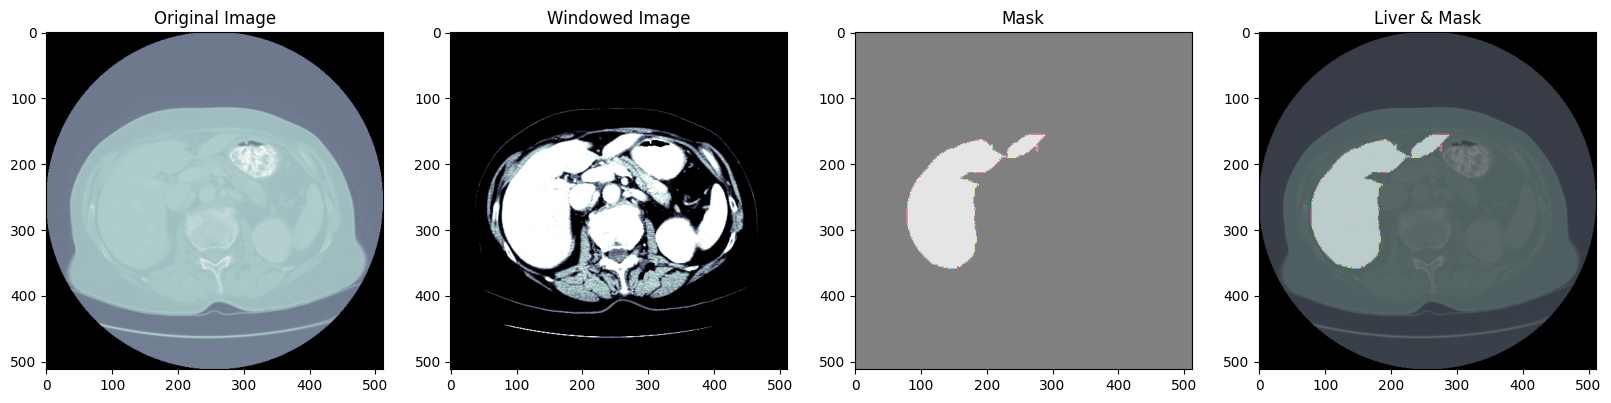

In [13]:
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])



In [14]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 244111]
 [     1  18033]]


<Axes: >

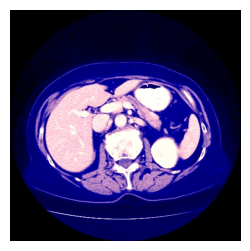

In [15]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [16]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 
"""

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = tensor(curr_mask[...,curr_slice].astype(np.float32))
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save_jpg(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.jpg", [dicom_windows.liver,dicom_windows.custom])
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output
    
"""

'\n\nGENERATE_JPG_FILES = True\n\nif (GENERATE_JPG_FILES) :\n    \n    path = Path(".")\n\n    os.makedirs(\'train_images\',exist_ok=True)\n    os.makedirs(\'train_masks\',exist_ok=True)\n\n    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training\n        curr_ct        = read_nii(df_files.loc[ii,\'dirname\']+"/"+df_files.loc[ii,\'filename\'])\n        curr_mask      = read_nii(df_files.loc[ii,\'mask_dirname\']+"/"+df_files.loc[ii,\'mask_filename\'])\n        curr_file_name = str(df_files.loc[ii,\'filename\']).split(\'.\')[0]\n        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim\n\n        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training\n            data = tensor(curr_ct[...,curr_slice].astype(np.float32))\n            mask = tensor(curr_mask[...,curr_slice].astype(np.float32))\n            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])\n            mask.sav

In [17]:
# Create a meta file for nii files processing
file_list = []
mask_list = []
for dirname, _, filenames in os.walk('C:/Users/dellG15/Documents/liver2/train_images'):
    for filename in filenames:
        file_list.append(filename) 

for dirname, _, filenames in os.walk('C:/Users/dellG15/Documents/liver2/train_masks'):
    for filename in filenames:
        mask_list.append(filename) 

files = pd.DataFrame({"train": file_list, "mask": mask_list}) 

ValueError: All arrays must be of the same length

In [ ]:
filename = []
for i in range(len(files)):
    root = "C:/Users/dellG15/Documents/liver2/train_images"
    path = os.path.join(root, files["train"][i])
    filename.append(path)

In [ ]:
mask = []
for i in range(len(files)):
    root = "C:/Users/dellG15/Documents/liver2/train_masks"
    path = os.path.join(root, files["train"][i])
    mask.append(path)

In [58]:
df = pd.DataFrame(data={"filename": filename, 'mask' : mask})

ValueError: If using all scalar values, you must pass an index

In [59]:
df['mask'] = df['mask'].str.split(".").str[0] + "_mask.jpg"

NameError: name 'df' is not defined

In [60]:
import cv2
import matplotlib.pyplot as plt

image= cv2.imread(df['mask'][5])
print(image.shape)
plt.imshow(image)
plt.show()

NameError: name 'df' is not defined

In [61]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size = 0.1, random_state = 42)
df_train, df_val = train_test_split(df_train,test_size = 0.2, random_state = 42)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

NameError: name 'df' is not defined

In [62]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import sys
# from mode.config import *
np.set_printoptions(threshold=sys.maxsize, precision=5, suppress=True)

# arg = command_arguments()
#########################configuration########################
tumor = [120,0,0]
liver = [0,255,0]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([ tumor, liver, Unlabelled])
class_name = [ 'tumor', 'liver', 'None']  # You must define by yourself

color = 'grayscale'

num_classes = 3 # include cat, dog and None.
# num_of_test_img = arg.img_num

test_img_size = 256 * 256

img_size = (256,256)
###############################################################



def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255.
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        mask[(mask!=0.)&(mask!=255.)&(mask!=128.)] = 0.
        new_mask = np.zeros(mask.shape + (num_class,))
        ########################################################################
        #You should define the value of your labelled gray imgs
        #For example,the imgs in /data/catndog/train/label/cat is labelled white
        #you got to define new_mask[mask == 255, 0] = 1
        #it equals to the one-hot array [1,0,0].
        ########################################################################
        new_mask[mask == 255.,   0] = 1
        new_mask[mask == 128.,   1] = 1
        new_mask[mask == 0.,   2] = 1
        mask = new_mask

    elif(np.max(img) > 1):
        img = img / 255.
        mask = mask /255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator( batch_size, dataframe, aug_dict, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
                    flag_multi_class = True, num_class = num_classes , save_to_dir = None, target_size = img_size, seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_dataframe(
        dataframe,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_dataframe(
        dataframe,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
#     print('classes:',image_generator.class_indices, mask_generator.class_indices)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

### You have to prepare validation data by your own while training
### If you prepared, add validation_data= "your own val path" in fit_generator in main.py
# def validationGenerator( batch_size, val_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
#                          mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
#                          flag_multi_class = True, num_class = num_classes , save_to_dir = None, target_size = img_size, seed = 1):

#     image_datagen = ImageDataGenerator()
#     mask_datagen  = ImageDataGenerator()
#     val_image_generator = image_datagen.flow_from_directory(
#         val_path+"image",
#         class_mode = None,
#         color_mode = image_color_mode,
#         target_size = target_size,
#         batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = image_save_prefix,
#         )
#     val_mask_generator = mask_datagen.flow_from_directory(
#         val_path+"label",
#         class_mode = None,
#         color_mode = mask_color_mode,
#         target_size = target_size,
#         batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = mask_save_prefix,
#         )
#     val_generator = zip(val_image_generator, val_mask_generator)
#     for (img,mask) in val_generator:
#         img ,mask = adjustData(img, mask, flag_multi_class, num_class)
#         yield (img,mask)

# def testGenerator(test_path,num_image = num_of_test_img, target_size = img_size, flag_multi_class=True, as_gray=True):
#     for i in range(num_image):
#         i = i + 1
#         img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
#         #img = img / 255.
#         img = trans.resize(img,target_size)
#         img = np.reshape(img,img.shape+(1,)) if (flag_multi_class) else img
#         img = np.reshape(img,(1,)+img.shape)
#         yield img


# ### You have to prepare test data by your own after training
# def testGenerator_for_evaluation(test_path, mask_path, num_image=num_of_test_img, num_class=num_classes ,target_size=(256,256), flag_multi_class = True, as_gray = True):
#     for i in range(num_image):
#         i = i + 1
#         # read test images
#         img = io.imread(os.path.join(test_path,"%d.png"%i), as_gray = as_gray)
#         img = trans.resize(img, target_size)
#         img = np.reshape(img,img.shape+(1,)) if (flag_multi_class) else img
#         img = np.reshape(img,(1,)+img.shape)
#         # read mask images
#         mask = io.imread(os.path.join(mask_path,"%d.png"%i), as_gray = as_gray)
#         mask = trans.resize(mask, target_size)
#         mask = np.expand_dims(mask,0)
#         mask = np.expand_dims(mask,-1)
#         mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
#         ###### filter noise points not related to the classes ######
#         mask[(mask!=0.)&(mask!=255.)&(mask!=128.)] = 0.
#         new_mask = np.zeros(mask.shape + (num_class,))
#         new_mask[(mask == 255.),   0] = 1
#         new_mask[(mask == 128.),   1] = 1
#         new_mask[(mask ==   0.),   2] = 1
#         mask = new_mask
#         yield (img,mask)



# ### draw imgs in labelVisualize and save results in saveResult
# def labelVisualize(num_class,  color_dict, img):
#     img_out = np.zeros(img[:,:,0].shape + (3,))
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             index_of_class = np.argmax(img[i,j])
#             img_out[i,j] = color_dict[index_of_class]
#     return img_out

# def saveResult(save_path,npyfile,flag_multi_class = True,num_class = num_classes ):
#     count = 1
#     for i,item in enumerate(npyfile):
#         if flag_multi_class:
#             img = labelVisualize(num_class,COLOR_DICT,item)
#             img = img.astype(np.uint8)
#             io.imsave(os.path.join(save_path,"%d.png"%count),img)
#         else:
#             img=item[:,:,0]
#             print(np.max(img),np.min(img))
#             img[img>0.5]=1
#             img[img<=0.5]=0
#             print(np.max(img),np.min(img))
#             img = img * 255.
#             io.imsave(os.path.join(save_path,"%d.png"%count),img)
#         count += 1

C:\ProgramData\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [63]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
# from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# from mode.config import *
# from tensorflow.contrib.opt import AdamWOptimizer
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras import backend as K
from keras.models import Model

img_size = (256,256,1) # 256 * 256 grayscale img with 1 channel

dr_rate = 0.6 # never mind
leakyrelu_alpha = 0.3

def unet(pretrained_weights = None,input_size = img_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)    
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(dr_rate)(pool1) ### 
    
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)
    #conv2 = Dropout(dr_rate)(conv2)###
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)    
    #conv2 = Dropout(dr_rate)(conv2)###    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)    
    #conv4 = Dropout(dr_rate)(conv4) ###
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)
    drop4 = Dropout(dr_rate)(conv4) ###
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    

    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)    
    conv5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #conv5 = Dropout(dr_rate)(conv5) ###
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #drop5 = Dropout(dr_rate)(conv5) ###

    up6 = Conv2D(512, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU(alpha=leakyrelu_alpha)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)
    #conv6 = Dropout(dr_rate)(conv6) ###
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)    
    #conv6 = Dropout(dr_rate)(conv6) ###   

    up7 = Conv2D(256, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = BatchNormalization()(up7)    
    up7 = LeakyReLU(alpha=leakyrelu_alpha)(up7)
    up7 = Dropout(dr_rate)(up7) ###
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)    
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)    
    #conv7 = Dropout(dr_rate)(conv7) ###
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)
    #conv7 = Dropout(dr_rate)(conv7) ###   

    up8 = Conv2D(128, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.3)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = LeakyReLU(alpha=0.3)(conv8)
    #conv8 = Dropout(dr_rate)(conv8) ###
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)    
    conv8 = LeakyReLU(alpha=0.3)(conv8)    
    #conv8 = Dropout(dr_rate)(conv8) ###    

    up9 = Conv2D(64, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=leakyrelu_alpha)(up9)
    up9 = Dropout(dr_rate)(up9) ###
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)    
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###

    conv10 = Conv2D(3, 1, activation = 'softmax')(conv9)
    model = Model(inputs = inputs, outputs = conv10)   
    model.compile(optimizer = Adam(lr = 3e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
import os
import os.path
# from model import *
# from data import *
from keras.models import load_model
from keras.callbacks import History
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras import backend as K
# from mode.config import *
# from csvrecord import * 
from pathlib import Path
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# arg = command_arguments()

# batch_size = arg.batchsize
# train_path = arg.train_path
# train_img_folder = arg.train_img_folder
# train_label_folder = arg.train_label_folder
# test_img_path = arg.test_img_path
# steps_per_epoch = arg.steps_per_epoch
# epochs = arg.epochs
# save_result_folder = arg.save_result_folder
# csvfilename = arg.csvfilename
# model_name = arg.model_name
# plt_save_name = arg.plt_save_name
# val_plt_name = arg.val_plt_name
# img_num = arg.img_num
# filenum = arg.filenum

#augs 

# rotation_range = arg.rotation_range
# width_shift_range = arg.width_shift_range
# height_shift_range = arg.height_shift_range
# zoom_range = arg.zoom_range
# horizontal_flip = arg.horizontal_flip
# fill_mode = arg.fill_mode


data_gen_args = dict()


#draw the training process of every epoch
# def show_train_history(train_history, train, loss, plt_save_name=plt_save_name):
#     plt.plot(train_history.history['acc'])
#     plt.plot(train_history.history['loss'])
#     plt.title('Train hist')
#     plt.ylabel(train)
#     plt.xlabel('Epoch')
#     plt.legend(['acc','loss'], loc='upper left')
#     plt.savefig(plt_save_name)

"""
##### training
myGene = trainGenerator(12, df_val, data_gen_args, save_to_dir = None)


model = unet()
# model_checkpoint = ModelCheckpoint(model_name, monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(myGene, steps_per_epoch=len(df_val)/32, epochs=1)
"""

"\n##### training\nmyGene = trainGenerator(12, df_val, data_gen_args, save_to_dir = None)\n\n\nmodel = unet()\n# model_checkpoint = ModelCheckpoint(model_name, monitor='loss',verbose=1, save_best_only=True)\nhistory = model.fit_generator(myGene, steps_per_epoch=len(df_val)/32, epochs=1)\n"

*Resnet*


In [18]:
from pathlib import Path

    # Replace '/path/to/model' with the actual path to the 'Liver_segmentation' folder
path = Path(os.path.join('C:\\', 'Users', 'dellG15', 'Documents', 'liver2\\'))
BATCH_SIZE = 4
IMAGE_SIZE = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.jpg'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/f'train_images')
print(ds)

(#10090) [(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)...]


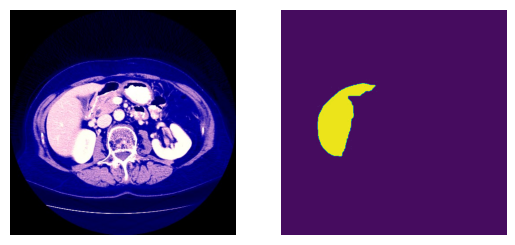

In [19]:
idx = 23
imgs = [ds[idx][0],ds[idx][1]]
fig, axs = plt.subplots(1, 2)

for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i])

In [20]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[    52     92]
 [    53 251774]
 [    54    183]
 [    82     77]
 [    83   9938]
 [    84     80]]


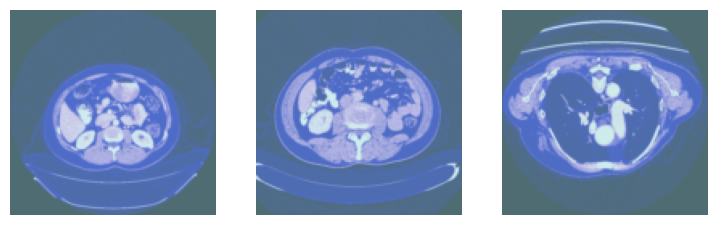

In [21]:
dls = db.dataloaders(path/'train_images', bs = 3) #, num_workers=0
dls.show_batch()

In [22]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [23]:
learn = unet_learner(dls,
                     resnet50,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc]) 

C:\Users\dellG15\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dellG15\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
#learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [27]:
"""

tfms = [Resize(IMAGE_SIZE), IntToFloatTensor(),Normalize()]
learn0 = load_learner(path/f'Liver_segmentation_1.pkl',cpu=False )
learn0.dls.transform = tfms
"""

SyntaxError: incomplete input (1728096728.py, line 1)

In [28]:
import pathlib

# Backup the original PosixPath
OriginalPosixPath = pathlib.PosixPath

# Override PosixPath to return a WindowsPath
pathlib.PosixPath = pathlib.WindowsPath

# Now, load your learner
learn0 = load_learner(path/f'Liver_segmentation_1.pkl', cpu=False)
learn0.dls.transform = tfms

# Restore the original PosixPath
pathlib.PosixPath = OriginalPosixPath


In [29]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices

(512, 512, 908)


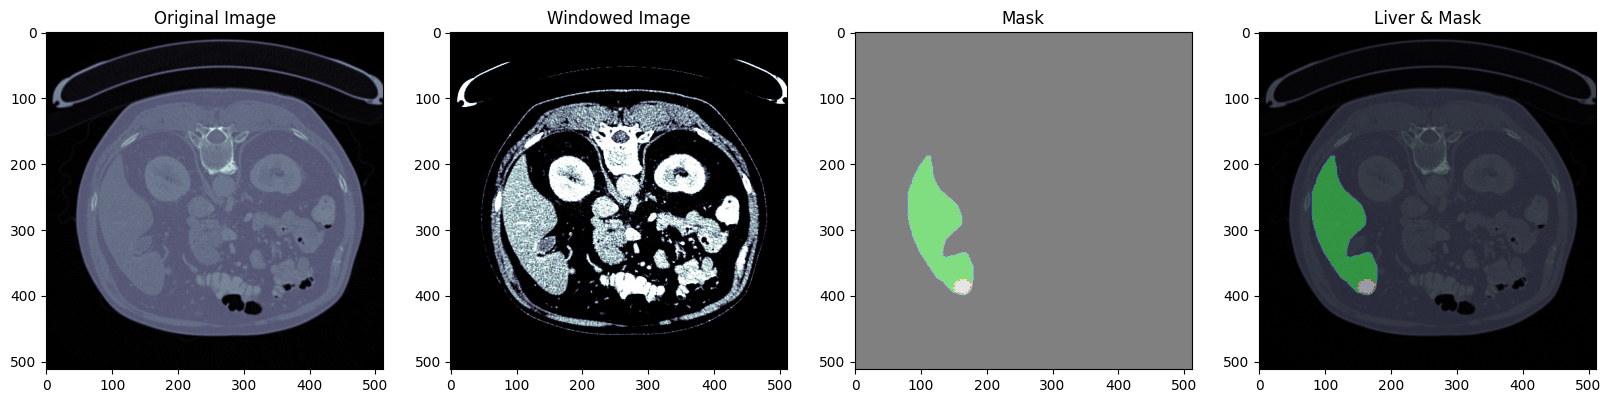

In [30]:
tst = 20

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [31]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ", len(test_files))

Number of test slices:  908


<Axes: >

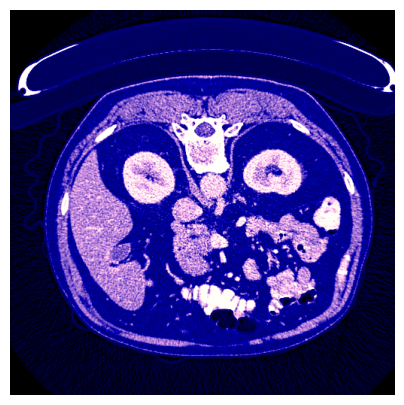

In [32]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

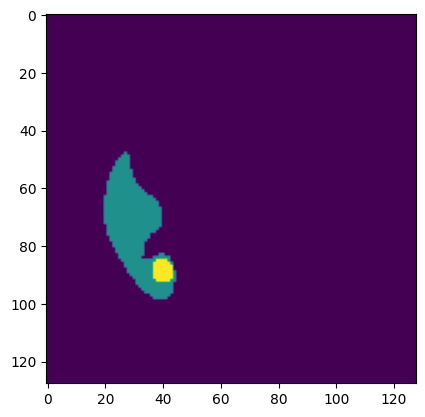

In [33]:
# Get predictions for a Test file
test_dl = learn0.dls.test_dl(test_files, device="cuda:0")
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)

plt.imshow(predicted_mask[test_slice_idx])

In [ ]:

# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test1 = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test1.flatten()

df.head(20)

In [ ]:
"""

import numpy as np
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# Assuming your plot_sample function looks something like this:
def plot_sample(images):
    fig, axs = plt.subplots(1, len(images))
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray')
    plt.show()

def read_nii(filepath):
    '''Reads .nii file and returns pixel array'''
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

# Same as before: Create a meta file for nii files processing
path = "C:/Users/dellG15/Documents/liverCysts"
file_list = []
for dirname, _, filenames in os.walk(path + '/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk(path + '/archive'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)    

# Map CT scan and label 
df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""
for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = path + "/liver-tumor-segmentation/segmentations"

df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

# Print images for all nii files in the folder
for index, row in df_files.iterrows():
    test_nii = read_nii(row['dirname'] + "/" + row['filename'])
    test_mask = read_nii(row['mask_dirname'] + "/" + row['mask_filename'])
    
    test_slice_idx = test_nii.shape[-1] // 2  # Choose the middle slice
    
    plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])
    
    

"""


In [ ]:
# ... [Earlier imports and functions]

# Loading the model and setting up transformations
learn = unet_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc])
tfms = [Resize(IMAGE_SIZE), IntToFloatTensor(), Normalize()]

# Handling the Windows-Posix path issue
OriginalPosixPath = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
learn0 = load_learner(path/f'Liver_segmentation_1.pkl', cpu=False)
learn0.dls.transform = tfms
pathlib.PosixPath = OriginalPosixPath

def nii_tfm(fn, wins): 
    test_nii = read_nii(fn)
    curr_dim = test_nii.shape[2]
    slices = []
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
    return slices

# Loop over all files and make predictions, then visualize the results
for index, row in df_files.iterrows():
    test_nii = read_nii(row['dirname'] + "/" + row['filename'])
    test_mask = read_nii(row['mask_dirname'] + "/" + row['mask_filename'])
    
    test_slice_idx = test_nii.shape[-1] // 2  # Choose the middle slice
    
    # Transforming the nii file for prediction
    test_files = nii_tfm(row['dirname'] + "/" + row['filename'], [dicom_windows.liver, dicom_windows.custom])
    test_dl = learn0.dls.test_dl(test_files, device="cuda:0")
    
    # Make predictions
    preds, y = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    
    # Plot CT scan, ground truth mask, and predicted mask
    plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx], predicted_mask[test_slice_idx]])


In [ ]:
from pathlib import Path



import numpy as np
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from fastai.vision.all import *
import pathlib


    # Replace '/path/to/model' with the actual path to the 'Liver_segmentation' folder
path = Path(os.path.join('C:\\', 'Users', 'dellG15', 'Documents', 'liver2\\'))
BATCH_SIZE = 4
IMAGE_SIZE = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.jpg'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/f'train_images')
print(ds)


# Constants
path = "C:/Users/dellG15/Documents/liver2"
IMAGE_SIZE = 512  # Adjust if your image size is different

# Load and preprocess data
file_list = []
for dirname, _, filenames in os.walk(path + '/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename))

for dirname, _, filenames in os.walk(path + '/archive'):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)

df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = path + "/liver-tumor-segmentation/segmentations"

df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

def read_nii(filepath):
    '''Reads .nii file and returns pixel array'''
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

def plot_sample(images):
    fig, axs = plt.subplots(1, len(images))
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray')
    plt.show()

def nii_tfm(fn, wins): 
    test_nii = read_nii(fn)
    curr_dim = test_nii.shape[2]
    slices = []
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
    return slices

# Load the learner/model
OriginalPosixPath = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
print(path+f'/Liver_segmentation_1.pkl')
learn0 = load_learner(path+f'/Liver_segmentation_1.pkl', cpu=False)
pathlib.PosixPath = OriginalPosixPath
tfms = [Resize(IMAGE_SIZE), IntToFloatTensor(), Normalize()]
learn0.dls.transform = tfms

# Loop over all files, make predictions, then visualize the results
for index, row in df_files.iterrows():
    test_nii = read_nii(row['dirname'] + "/" + row['filename'])
    test_mask = read_nii(row['mask_dirname'] + "/" + row['mask_filename'])
    test_slice_idx = test_nii.shape[-1] // 2  # Choose the middle slice
    
    # Transforming the nii file for prediction
    test_files = nii_tfm(row['dirname'] + "/" + row['filename'], [dicom_windows.liver, dicom_windows.custom])
    test_dl = learn0.dls.test_dl(test_files, device="cuda:0")
    
    # Make predictions
    preds, y = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)
    
    # Plot CT scan, ground truth mask, and predicted mask
    plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx], predicted_mask[test_slice_idx]])


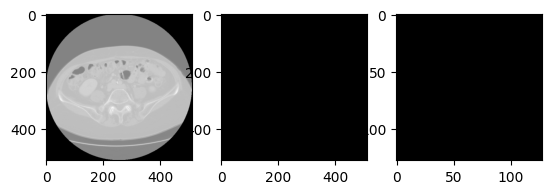

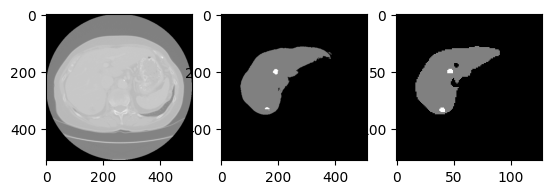

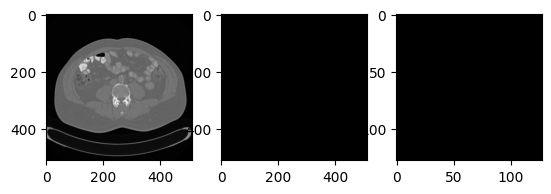

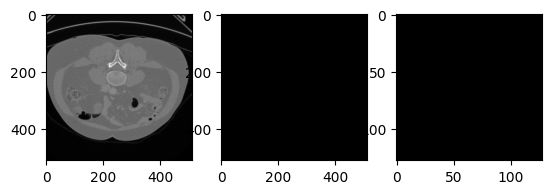

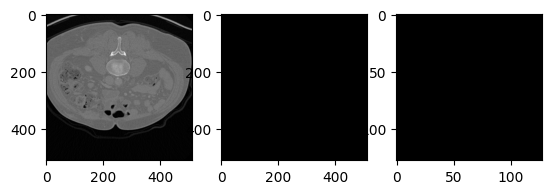

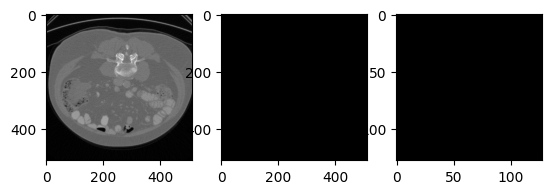

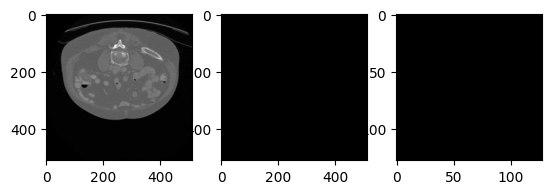

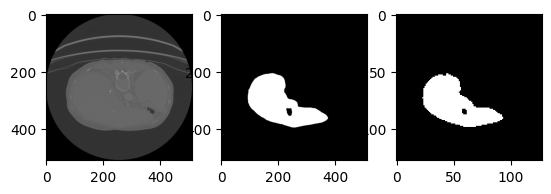

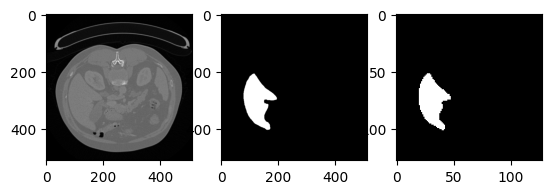

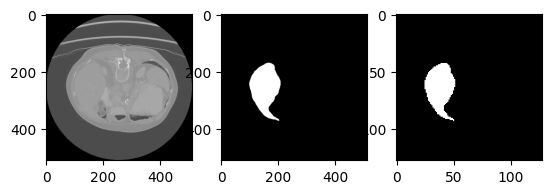

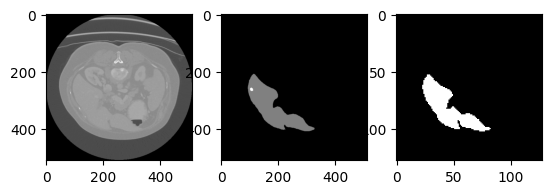

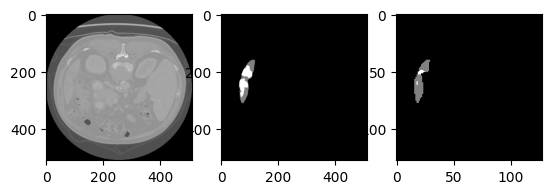

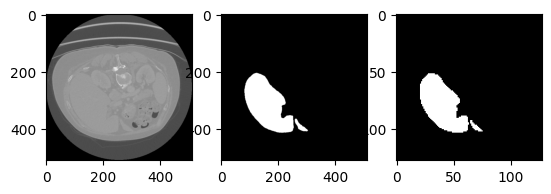

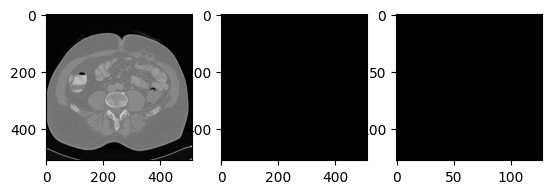

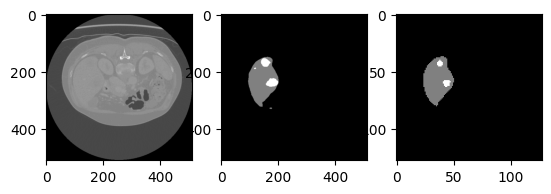

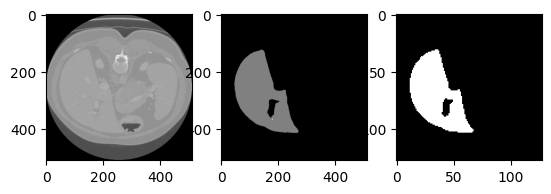

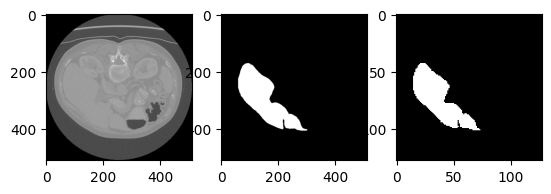

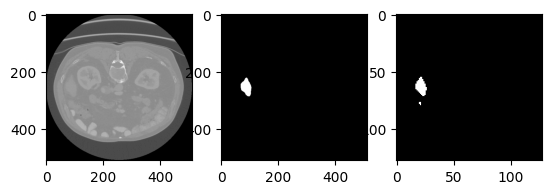

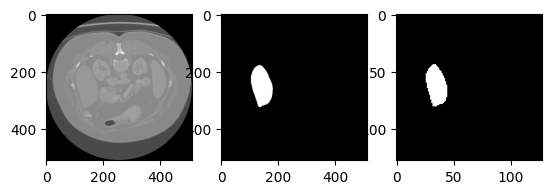

In [ ]:
import numpy as np
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming you've imported necessary libraries for your model and defined the necessary transformations and utility functions

# Assuming your plot_sample function looks something like this:
def plot_sample(images):
    fig, axs = plt.subplots(1, len(images))
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray')
    plt.show()

def read_nii(filepath):
    '''Reads .nii file and returns pixel array'''
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return array

# Load your model
# Assuming learn0 is your model's name
# learn0 = load_model("path_to_your_model")

path = "C:/Users/dellG15/Documents/liverCysts"
file_list = []

# Process as before
# ... 

df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

# Print images for all nii files in the folder
for index, row in df_files.iterrows():
    test_nii = read_nii(row['dirname'] + "/" + row['filename'])
    test_mask = read_nii(row['mask_dirname'] + "/" + row['mask_filename'])
    
    test_slice_idx = test_nii.shape[-1] // 2  # Choose the middle slice

    # Prediction
    test_files = nii_tfm(row['dirname'] + "/" + row['filename'], [dicom_windows.liver, dicom_windows.custom])
    test_dl = learn0.dls.test_dl(test_files, device="cuda:0")
    preds, _ = learn0.get_preds(dl=test_dl)
    predicted_mask = np.argmax(preds, axis=1)

    # Display
    plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx], predicted_mask[test_slice_idx]])
